In [1]:
! eups list -s lsst_distrib

   gdf42428520+f51fc98903 	current w_2023_23 setup


In [219]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
from matplotlib import lines
from mpl_toolkits import axes_grid1
import lsst.daf.butler as daf_butler
import lsst.afw.display as afwDisplay
from  lsst.eo.pipe.plotting import plotting_utils

from astropy.visualization import imshow_norm, MinMaxInterval,AsinhStretch,LinearStretch,SqrtStretch,ContrastBiasStretch,ZScaleInterval,AsymmetricPercentileInterval,ManualInterval

from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()

from myutils import *

In [18]:
import lsst.afw.math as afwMath
from lsst.afw.cameraGeom import utils as cgu

class UserImageSource:
    isTrimmed = True
    background = 0.0

    def __init__(self, butler, exposure_refs):
        self.butler = butler
        self.exposure_refs = exposure_refs

    def getCcdImage(self, det, imageFactory, binSize=1, *args, **kwargs):
        ccdImage = self.butler.get(self.exposure_refs[det.getId()]).getImage()
        ccdImage = afwMath.binImage(ccdImage, binSize)
        return afwMath.rotateImageBy90(ccdImage,
                                       det.getOrientation().getNQuarter()), det


def make_mosaic(butler, exposure_refs, camera, binSize):
    detectorNameList = [camera[detector].getName() for
                        detector in exposure_refs]
    image_source = UserImageSource(butler, exposure_refs)
    return cgu.showCamera(camera, imageSource=image_source,
                          detectorNameList=detectorNameList,
                          binSize=binSize)

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [199]:
def build_where(acq_run=None,physical_filter=None,obs_id=None,observation_type=None,observation_reason=None):
    
    select = " \n instrument='LSSTCam' "
    if acq_run:
        select += " and exposure.science_program='%s' "%(acq_run)
    if physical_filter:
        select += " and physical_filter='%s' "%(physical_filter)
    if obs_id:
        select += " and exposure.obs_id in ( '%s' ) "%(obs_id)
    if observation_type:
        select += " and exposure.observation_type in ( '%s' ) "%(observation_type)
    if observation_reason:
        select += " and exposure.observation_reason in ( '%s' ) "%(observation_reason)
    select += "\n"
    
    return select

def get_exposure_refs(acq_run,datasetType,physical_filter=None,obs_id=None,weekly='w_2023_24',operator='lsstccs',repo='/repo/ir2',doexp=True,verbose=0):
    
    # We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
    # the specified run.  For our dataset queries, we'll use these collections.
    butler = daf_butler.Butler(repo)
    collections = butler.registry.queryCollections(f"u/{operator}/*_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
    if verbose>0:
        for item in collections:
            print(item)
        
        
    select = build_where(physical_filter=physical_filter,obs_id=obs_id)
    if verbose>0:
        print(select)
    
    dsrefs = list(set(butler.registry.queryDatasets(collections=collections,datasetType=datasetType,where=select)))
    if doexp:
        exposure_refs = {ref.dataId['detector']: ref for ref in dsrefs}
    else:
        exposure_refs = None
    
    return dsrefs,exposure_refs


# Get the super flat and lambda images from Run 13378

In [216]:
acq_run = '13391'
dsrefs_sflathi,exp_sflathi = get_exposure_refs(acq_run,'flat')
print(len(dsrefs_sflathi))

dsrefs_lambda = {}
exp_lambda = {}
filts = ['uv','blue','red','nm750','nm850','nm960']
for afilt in filts:
    dsrefs_lambda[afilt],exp_lambda[afilt] = get_exposure_refs(acq_run,'postISRCCD',physical_filter=afilt)
    print(len(dsrefs_lambda[afilt]))

dsrefs_dark,exp_dark = get_exposure_refs(acq_run,'dark')
print(len(dsrefs_dark))

dsrefs_raw,exp_raw = get_exposure_refs(acq_run,'raw',obs_id='MC_C_20230619_000198')
print(len(dsrefs_raw))

205
205
205
205
205
205
205
205
205


In [217]:
dsrefs_isrconfig,_ = get_exposure_refs(acq_run,'isr_config',doexp=False)
print(len(dsrefs_isrconfig))

repo='/repo/ir2'
butler = daf_butler.Butler(repo)
an_isrconfig = butler.get(dsrefs_isrconfig[0])
for anitem in isrconfig.items():
    print(anitem)

10
('saveMetadata', True)
('saveLogOutput', True)
('datasetType', 'raw')
('fallbackFilterName', None)
('useFallbackDate', False)
('expectWcs', True)
('fwhm', 1.0)
('qa', lsst.ip.isr.isrQa.IsrQaConfig(saveStats=True, flatness={'meshX': 256, 'meshY': 256, 'doClip': True, 'clipSigma': 3.0, 'nIter': 3}, doWriteOss=False, doThumbnailOss=False, doWriteFlattened=False, doThumbnailFlattened=False, thumbnailBinning=4, thumbnailStdev=3.0, thumbnailRange=5.0, thumbnailQ=20.0, thumbnailSatBorder=2))
('doHeaderProvenance', True)
('doRaiseOnCalibMismatch', False)
('cameraKeywordsToCompare', [])
('doConvertIntToFloat', True)
('doSaturation', False)
('saturatedMaskName', 'SAT')
('saturation', nan)
('growSaturationFootprintSize', 1)
('doSuspect', False)
('suspectMaskName', 'SUSPECT')
('numEdgeSuspect', 0)
('edgeMaskLevel', 'DETECTOR')
('doSetBadRegions', True)
('badStatistic', 'MEANCLIP')
('doOverscan', True)
('overscan', <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7f4b441f00a0>

# some sample position code

In [218]:
from lsst.afw.cameraGeom import FOCAL_PLANE, FIELD_ANGLE
adet = camera['R01_S02']
print(f"{adet.getCenter(FIELD_ANGLE) = } (radians)")
print(f"{adet.getCenter(FOCAL_PLANE) = } (mm)")
print(adet.getCorners(FOCAL_PLANE))

adet.getCenter(FIELD_ANGLE) = Point2D(-0.008218561522168856, -0.028726180233102225) (radians)
adet.getCenter(FOCAL_PLANE) = Point2D(-84.760000000000005, -296.25999999999999) (mm)
[Point2D(-105.12, -316.25999999999999), Point2D(-64.400000000000006, -316.25999999999999), Point2D(-64.400000000000006, -276.25999999999999), Point2D(-105.12, -276.25999999999999)]


# make a Mosaic

In [223]:
repo='/repo/ir2'
butler = daf_butler.Butler(repo)

mosaic_lambda = {}
for afilt in filts:
    print('Make mosaic for Filter ',afilt)
    start = time.time()
    mosaic_lambda[afilt] = make_mosaic(butler,exp_lambda[afilt],camera,binSize=8)
    finish = time.time()
    print('Time taken ',finish-start)


Make mosaic for Filter  uv
Time taken  236.20170140266418
Make mosaic for Filter  blue
Time taken  234.02554082870483
Make mosaic for Filter  red
Time taken  242.5328450202942
Make mosaic for Filter  nm750
Time taken  238.5009961128235
Make mosaic for Filter  nm850
Time taken  238.04915833473206
Make mosaic for Filter  nm960
Time taken  228.1175525188446


In [224]:
mmosaic_lambda = {}
for afilt in filts:
    aarr = mosaic_lambda[afilt].getArray()
    mmosaic_lambda[afilt] = np.ma.filled(np.ma.masked_values(aarr,0.0000),np.nan)

12098.413061523437 14679.056640625


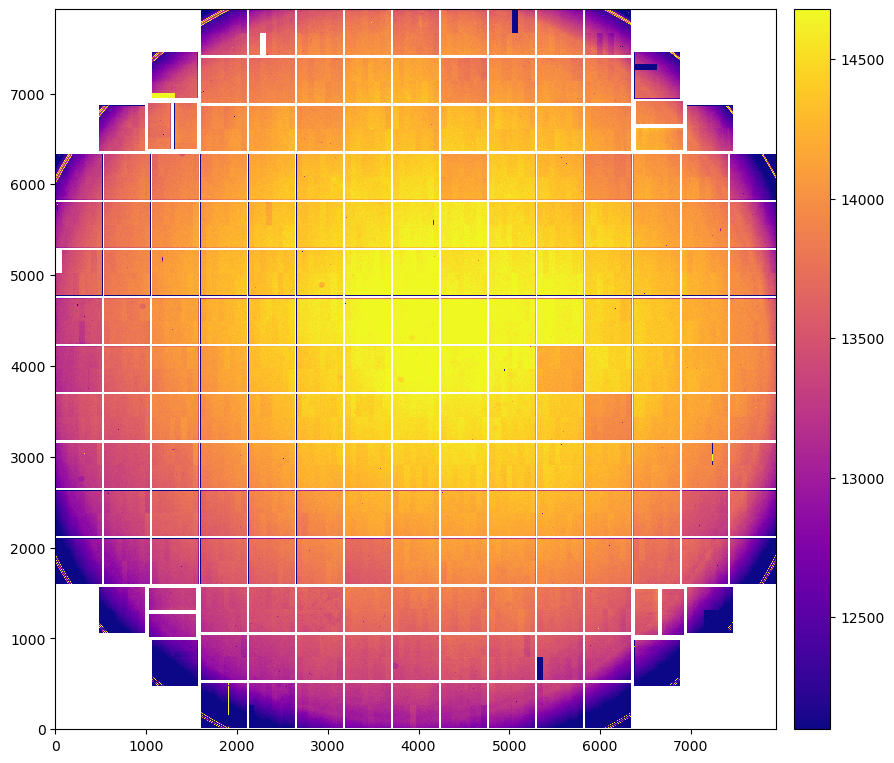

In [226]:
lo,hi = np.nanpercentile(mmosaic_lambda['nm750'],[2.5,97.5])
print(lo,hi)

f,ax = plt.subplots(1,1,figsize=(10.,10.))

im, norm = imshow_norm(mmosaic_lambda['nm750'], ax, origin='lower', interpolation='None',cmap='plasma',
                       interval=ManualInterval(lo,hi),
                       stretch=LinearStretch())
add_colorbar(im)
f.savefig("mosaic_nm750_%s.pdf"%(acq_run))


In [227]:
f.savefig("mosaic_nm750_%s.png"%(acq_run),dpi=1200)


In [ ]:
for afilt in filts:
    lo,hi = np.nanpercentile(mmosaic_lambda[afilt],[2.5,97.5])
    print(lo,hi)

    f,ax = plt.subplots(1,1,figsize=(10.,10.))

    im, norm = imshow_norm(mmosaic_lambda[afilt], ax, origin='lower', interpolation='None',cmap='plasma',
                       interval=ManualInterval(lo,hi),
                       stretch=LinearStretch())
    add_colorbar(im)
    f.savefig("mosaic_%s_%s.png"%(afilt,acq_run),dpi=600)


15821.1044921875 21541.1640625
